In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

In [0]:
""" 
Generates a random value assigned to each hidden 
unit to model dependencies between dimensions or
an even sequential split for the first and last layers.
"""

def get_mk(num_dim, output_size, last=False):
    if last == False:
        mk = np.random.randint(1, num_dim, output_size)

    else:
        for i in range(1, num_dim + 1):
            if i == 1:
                mk = np.random.randint(i, i + 1, output_size//num_dim)
            else:
                mk = np.concatenate((mk, np.random.randint(i, i + 1, output_size//num_dim)))
    return mk


""" Masks the weights of each hidden unit given the networks dependency structure """

def get_mask(prev_mk, mk, output_size, last=False):
    input_size = len(prev_mk)

    mask = torch.ones(output_size, input_size)

    for i in range(len(mask)):
        for j in range(len(mask[i])):
            if last == False:
                if mk[i] >= prev_mk[j]:
                    mask[i][j] = 1.
                else:
                    mask[i][j] = 0.
            else:
                if mk[i] > prev_mk[j]:
                    mask[i][j] = 1.
                else:
                    mask[i][j] = 0.

    return mask

In [0]:
""" Applies mask to each hidden layer """

class MaskedLayer(nn.Linear):

    def __init__(self, in_features, out_features, mask, bias=True):
        super().__init__(in_features, out_features, bias)

        self.mask = mask

    def forward(self, input):
        return F.linear(input, torch.mul(self.mask, self.weight), self.bias)


class MADE(nn.Module):
    def __init__(self, mask_1, mask_2, mask_3):
        super(MADE, self).__init__()

        self.l1 = MaskedLayer(400, 400, mask_1)
        self.l2 = MaskedLayer(400, 400, mask_2)
        self.l3 = MaskedLayer(400, 400, mask_3)

    def forward(self, input):
        model = torch.nn.Sequential(
            self.l1,
            torch.nn.ReLU(),
            self.l2,
            torch.nn.ReLU(),
            self.l3)

        return model(input)

In [0]:
torch.manual_seed(0)

""" Precomputes masks for each layer of the network. Saves time during training.
    Obviously not ideal for a larger network """

num_dim = 2
mk_0 = get_mk(num_dim, 400, True)
mk_1 = get_mk(num_dim, 400)
mk_2 = get_mk(num_dim, 400)
mk_3 = get_mk(num_dim, 400, True)

mask_1 = get_mask(mk_0, mk_1, 400)
mask_2 = get_mask(mk_1, mk_2, 400)
mask_3 = get_mask(mk_2, mk_3, 400, True)

made = MADE(mask_1, mask_2, mask_3)

In [0]:
batch_size = 512
x = np.load('distribution.npy')
samples = np.random.choice(x.flatten().shape[0], size=(100000,), p=x.flatten())
indices = np.unravel_index(samples, shape=x.shape)
index_pairs = np.stack(indices, axis=-1)

train_set, validation_set, test_set = torch.utils.data.random_split(index_pairs,
                                                                    (int(len(index_pairs) * .6),
                                                                      int(len(index_pairs) * .2),
                                                                      int(len(index_pairs) * .2)))

training_data = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

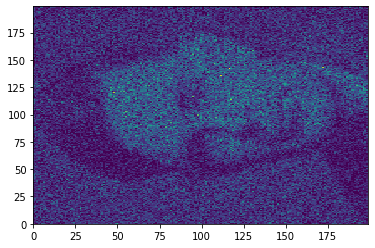

In [60]:
""" Visualization of the given distribution """

plt.hist2d(index_pairs[:,0], index_pairs[:,1], bins=200, range=np.array([[0,199], [0,199]]))
plt.show()

In [61]:
epochs = 50
optimizer = torch.optim.Adam(made.parameters(), lr=0.001)

training_loss = []
validation_loss = []

""" Training loop """

for i in range(epochs):
    j = 0
    for batch in training_data:
        optimizer.zero_grad()

        one_hot = F.one_hot(batch.flatten(), num_classes=200).float()
        one_hot = one_hot.view(len(batch),400)

        logits = made.forward(one_hot)
        logits = logits.view(len(batch),2,200)
        
        """ Convert to log base 2"""

        loss = F.cross_entropy(logits.flatten(0,1), batch.flatten()) * np.log2(np.e)

        if j == len(training_data)-1 or (i == 0 and j == 0):
          print("Epoch:",i, "  Batch:",j,"  Loss:",loss.item(),"bits/dim")

        loss.backward()
        optimizer.step()
        training_loss.append(loss)
        j += 1


Epoch: 0   Batch: 0   Loss: 7.643193244934082 bits/dim
Epoch: 0   Batch: 117   Loss: 7.623283386230469 bits/dim
Epoch: 1   Batch: 117   Loss: 7.614433288574219 bits/dim
Epoch: 2   Batch: 117   Loss: 7.581707954406738 bits/dim
Epoch: 3   Batch: 117   Loss: 7.586211204528809 bits/dim
Epoch: 4   Batch: 117   Loss: 7.569845676422119 bits/dim
Epoch: 5   Batch: 117   Loss: 7.6255388259887695 bits/dim
Epoch: 6   Batch: 117   Loss: 7.605424880981445 bits/dim
Epoch: 7   Batch: 117   Loss: 7.527869701385498 bits/dim
Epoch: 8   Batch: 117   Loss: 7.49561071395874 bits/dim
Epoch: 9   Batch: 117   Loss: 7.573607444763184 bits/dim
Epoch: 10   Batch: 117   Loss: 7.515890598297119 bits/dim
Epoch: 11   Batch: 117   Loss: 7.526105880737305 bits/dim
Epoch: 12   Batch: 117   Loss: 7.560801029205322 bits/dim
Epoch: 13   Batch: 117   Loss: 7.488947868347168 bits/dim
Epoch: 14   Batch: 117   Loss: 7.507511615753174 bits/dim
Epoch: 15   Batch: 117   Loss: 7.428020000457764 bits/dim
Epoch: 16   Batch: 117   Lo

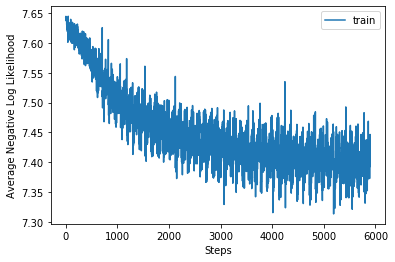

In [62]:
""" Training Loss Curve """

plt.xlabel('Steps')
plt.ylabel('Average Negative Log Likelihood')
plt.plot(training_loss, label='train')
plt.legend()
plt.show()

In [0]:
""" The first dimension is independent of input so the biases are the logits """

made.eval()
bias = made.l3.bias[0:200]

In [0]:
""" Sample the first dimension """

sm = torch.nn.Softmax(dim=0)
dim_1_probs = sm(bias)
dim_1_prob_dist = torch.distributions.Categorical(dim_1_probs)
dim_1_samples = dim_1_prob_dist.sample([100000,2])

In [0]:
"""" Sample the second dimension """

one_hot = F.one_hot(dim_1_samples.flatten(), num_classes=200).float()
one_hot = one_hot.view(len(dim_1_samples),400)

one_two_logits = made.forward(one_hot)
dim_2_logits = one_two_logits[:,200:400]
sm = torch.nn.Softmax(dim=1)
dim_2_probs = sm(dim_2_logits)
dim_2_prob_dist = torch.distributions.Categorical(dim_2_probs)
dim_2_samples = dim_2_prob_dist.sample([1])

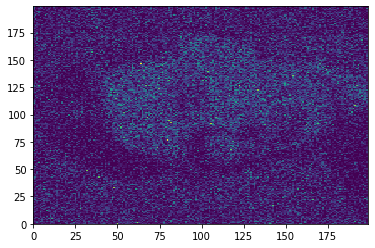

In [66]:
""" Plot the samples """

plt.hist2d(dim_1_samples[:, 0].numpy(), dim_2_samples[0].numpy(), 
           bins=200, range=np.array([[0, 199], [0, 199]]))
plt.show()